# Chapter 5: Fitting models to data

In [1]:
library(tidyverse)
library(NHANES)
library(cowplot)
library(mapproj)
library(pander)
library(knitr)
library(modelr)

panderOptions('round',2)
panderOptions('digits',7)
theme_set(theme_minimal(base_size = 14))

options(digits = 2)
set.seed(123456) # set random seed to exactly replicate results

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


ERROR: Error in library(mapproj): there is no package called ‘mapproj’


## Figure 5.1

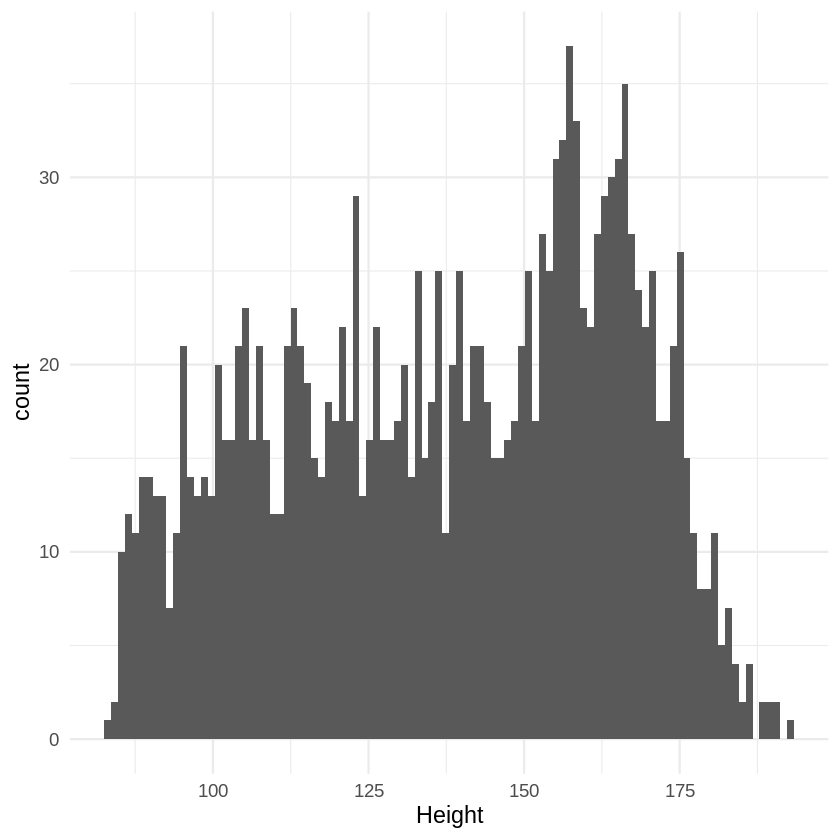

In [4]:
# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID, .keep_all = TRUE)

# select the appropriate children with good height measurements

NHANES_child <-
  NHANES %>%
  drop_na(Height) %>%
  subset(Age < 18)

NHANES_child %>%
  ggplot(aes(Height)) +
  geom_histogram(bins = 100)

## Figure 5.2

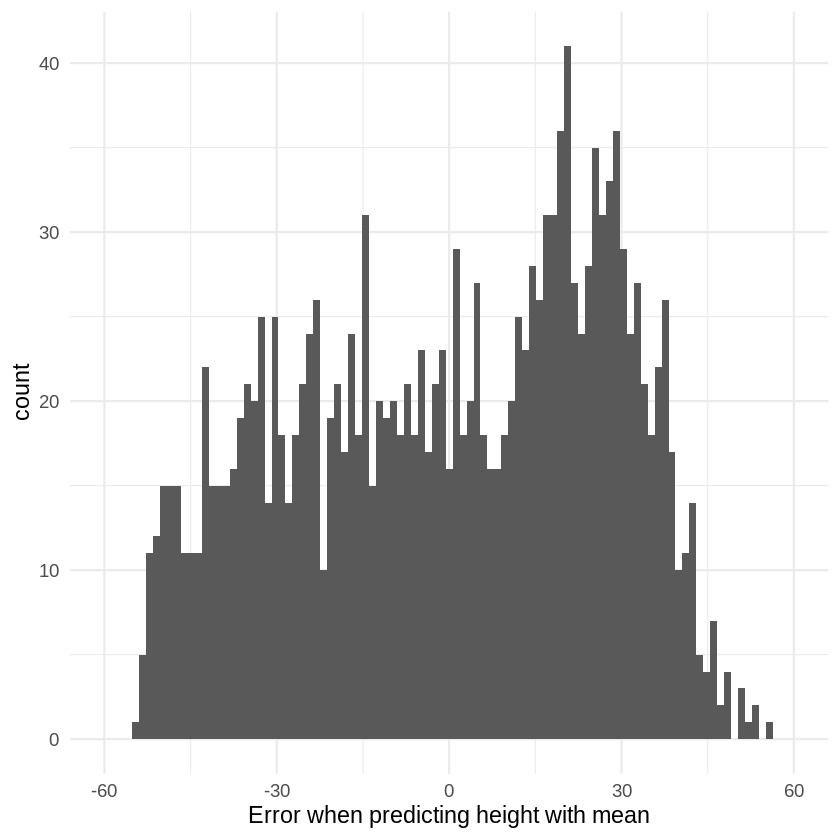

In [5]:
# compute error compared to the mean and plot histogram

error_mean <- NHANES_child$Height - mean(NHANES_child$Height)

ggplot(NULL, aes(error_mean)) +
  geom_histogram(bins = 100) +
  xlim(-60, 60) +
  labs(
    x = "Error when predicting height with mean"
  )

## Figure 5.3

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


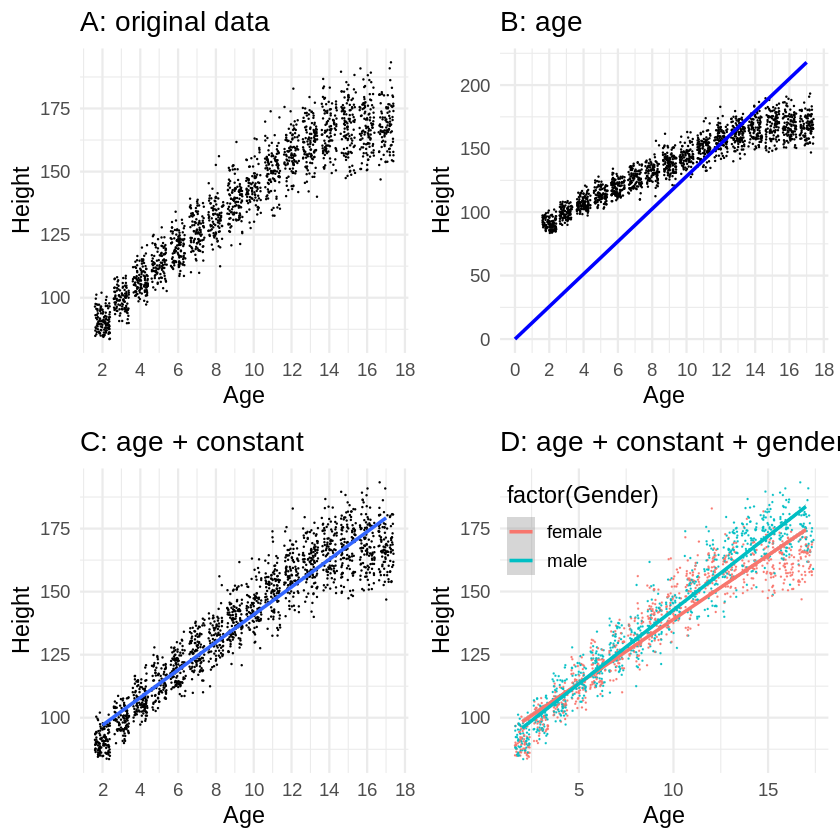

In [6]:
# compute and print RMSE for mean and mode
rmse_mean <- sqrt(mean(error_mean**2))

# from https://www.tutorialspoint.com/r/r_mean_median_mode.htm
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

error_mode <- NHANES_child$Height - getmode(NHANES_child$Height)
rmse_mode <- sqrt(mean(error_mode**2))

p1 <- NHANES_child %>%
  ggplot(aes(x = Age, y = Height)) +
  geom_point(position = "jitter",size=0.05) +
  scale_x_continuous(breaks = seq.int(0, 20, 2)) +
  ggtitle('A: original data')

lmResultHeightOnly <- lm(Height ~ Age + 0, data=NHANES_child)
rmse_heightOnly <- sqrt(mean(lmResultHeightOnly$residuals**2))

p2 <- NHANES_child %>%
  ggplot(aes(x = Age, y = Height)) +
  geom_point(position = "jitter",size=0.05) +
  scale_x_continuous(breaks = seq.int(0, 20, 2)) +
  annotate('segment',x=0,xend=max(NHANES_child$Age),
           y=0,yend=max(lmResultHeightOnly$fitted.values),
           color='blue',lwd=1) +
  ggtitle('B: age')

p3 <- NHANES_child %>%
  ggplot(aes(x = Age, y = Height)) +
  geom_point(position = "jitter",size=0.05) +
  scale_x_continuous(breaks = seq.int(0, 20, 2)) +
  geom_smooth(method='lm',se=FALSE) +
  ggtitle('C: age + constant')

p4 <- NHANES_child %>%
  ggplot(aes(x = Age, y = Height)) +
  geom_point(aes(colour = factor(Gender)),
             position = "jitter",
             alpha = 0.8,
             size=0.05) +
  geom_smooth(method='lm',aes(group = factor(Gender),
                              colour = factor(Gender))) +
  theme(legend.position = c(0.25,0.8)) +
  ggtitle('D: age + constant + gender')

plot_grid(p1,p2,p3,p4,ncol=2)

## Figure 5.4

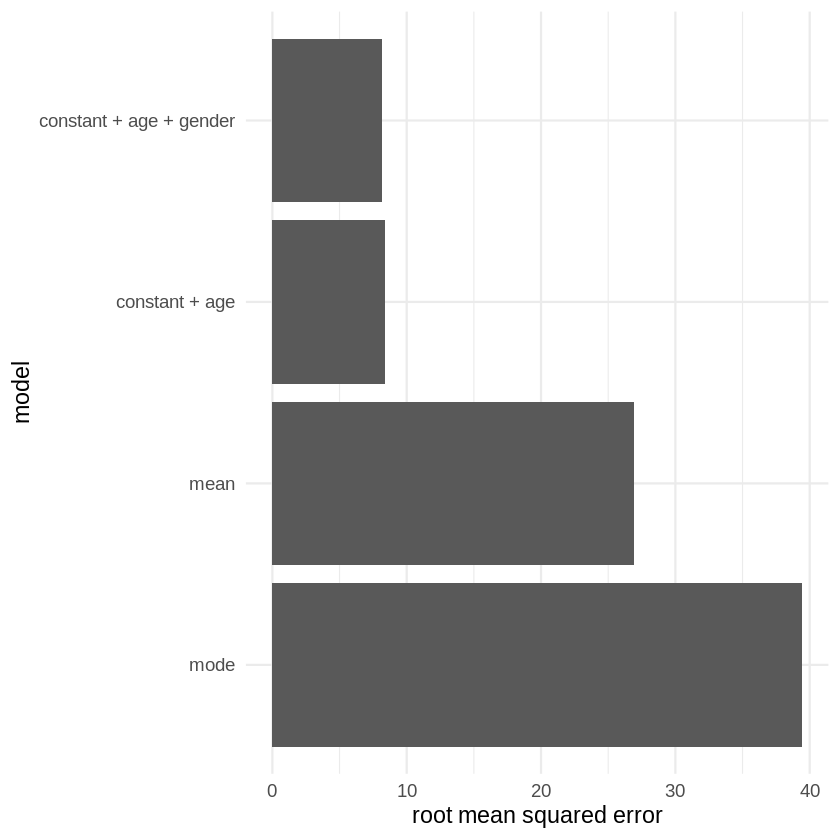

In [7]:
# find the best fitting model to predict height given age
model_age <- lm(Height ~ Age, data = NHANES_child)

# the add_predictions() function uses the fitted model to add the predicted values for each person to our dataset
NHANES_child <-
  NHANES_child %>%
  add_predictions(model_age, var = "predicted_age") %>%
  mutate(
    error_age = Height - predicted_age #calculate each individual's difference from the predicted value
  )

rmse_age <-
  NHANES_child %>%
  summarise(
    sqrt(mean((error_age)**2)) #calculate the root mean squared error
  ) %>%
  pull()

# compute model fit for modeling with age and gender

model_age_gender <- lm(Height ~ Age + Gender, data = NHANES_child)

rmse_age_gender <-
  NHANES_child %>%
  add_predictions(model_age_gender, var = "predicted_age_gender") %>%
  summarise(
    sqrt(mean((Height - predicted_age_gender)**2))
  ) %>%
  pull()

error_df <- #build a dataframe using the function tribble()
  tribble(
    ~model, ~error,
    "mode", rmse_mode,
    "mean", rmse_mean,
    "constant + age", rmse_age,
    "constant + age + gender", rmse_age_gender
  ) %>%
  mutate(
    RMSE = error
  )

error_df %>%
  ggplot(aes(x = model, y = RMSE)) +
  geom_col() +
  scale_x_discrete(limits = c("mode", "mean", "constant + age", "constant + age + gender")) +
  labs(
    y = "root mean squared error"
  ) +
  coord_flip()

## Figure 5.5

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


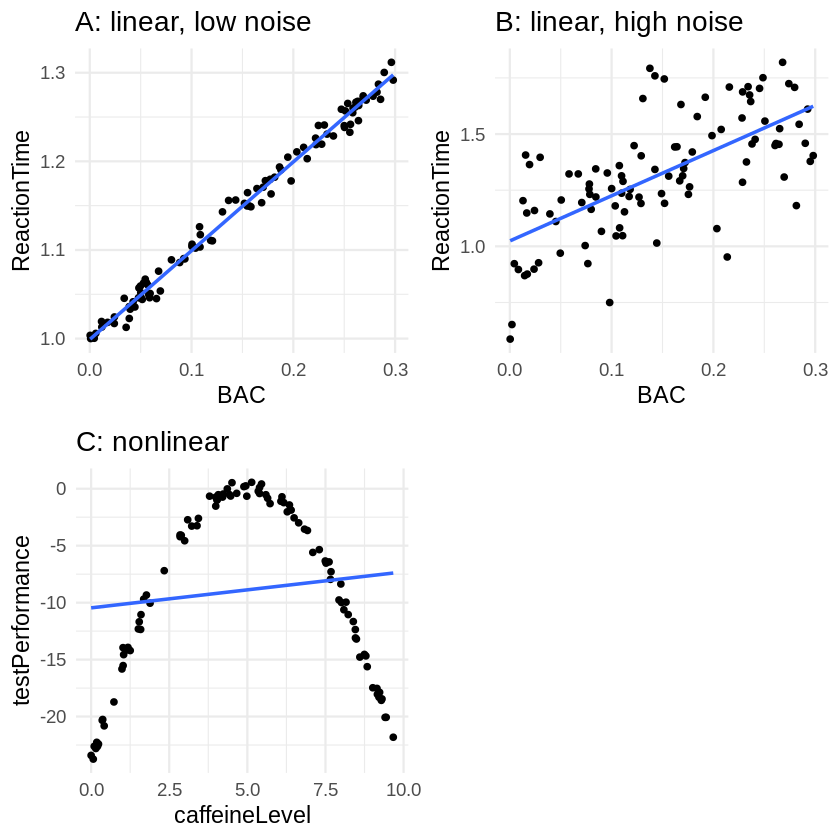

In [8]:
dataDf <-
  tibble(
    BAC = runif(100) * 0.3,
    ReactionTime = BAC * 1 + 1 + rnorm(100) * 0.01
  )

p1 <- dataDf %>%
  ggplot(aes(x = BAC, y = ReactionTime)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  ggtitle('A: linear, low noise')

# noisy version
dataDf <-
  tibble(
    BAC = runif(100) * 0.3,
    ReactionTime = BAC * 2 + 1 + rnorm(100) * 0.2
  )

p2 <- dataDf %>%
  ggplot(aes(x = BAC, y = ReactionTime)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  ggtitle('B: linear, high noise')

# nonlinear (inverted-U) function

dataDf <-
  dataDf %>%
  mutate(
    caffeineLevel = runif(100) * 10,
    caffeineLevelInvertedU = (caffeineLevel - mean(caffeineLevel))**2,
    testPerformance = -1 * caffeineLevelInvertedU + rnorm(100) * 0.5
  )

p3 <- dataDf %>%
  ggplot(aes(x = caffeineLevel, y = testPerformance)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  ggtitle('C: nonlinear')

plot_grid(p1,p2,p3)

## Figure 5.6

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


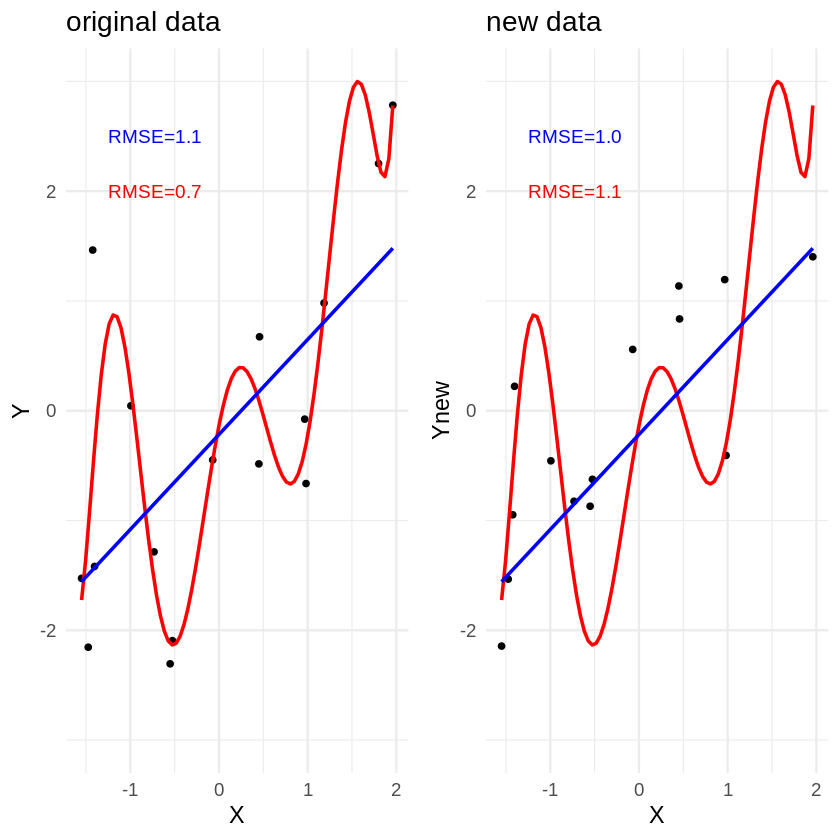

In [9]:
#parameters for simulation
set.seed(1122)
sampleSize <- 16


#build a dataframe of simulated data
simData <-
  tibble(
    X = rnorm(sampleSize),
    Y = X + rnorm(sampleSize, sd = 1),
    Ynew = X + rnorm(sampleSize, sd = 1)
  )

#fit models to these data
simpleModel <- lm(Y ~ X, data = simData)
complexModel <- lm(Y ~ poly(X, 8), data = simData)

#calculate root mean squared error for "current" dataset
rmse_simple <- sqrt(mean(simpleModel$residuals**2))
rmse_complex <- sqrt(mean(complexModel$residuals**2))

#calculate root mean squared error for "new" dataset
rmse_prediction_simple <- sqrt(mean((simpleModel$fitted.values - simData$Ynew)**2))
rmse_prediction_complex <- sqrt(mean((complexModel$fitted.values - simData$Ynew)**2))

#visualize
plot_original_data <-
  simData %>%
  ggplot(aes(X, Y)) +
  geom_point() +
  geom_smooth(
    method = "lm",
    formula = y ~ poly(x, 8),
    color = "red",
    se = FALSE
  ) +
  geom_smooth(
    method = "lm",
    color = "blue",
    se = FALSE
  ) +
  ylim(-3, 3) +
  annotate(
    "text",
    x = -1.25,
    y = 2.5,
    label = sprintf("RMSE=%0.1f", rmse_simple),
    color = "blue",
    hjust = 0,
    cex = 4
  ) +
  annotate(
    "text",
    x = -1.25,
    y = 2,
    label = sprintf("RMSE=%0.1f", rmse_complex),
    color = "red",
    hjust = 0,
    cex = 4
  ) +
  ggtitle("original data")

plot_new_data  <-
  simData %>%
  ggplot(aes(X, Ynew)) +
  geom_point() +
  geom_smooth(
    aes(X, Y),
    method = "lm",
    formula = y ~ poly(x, 8),
    color = "red",
    se = FALSE
  ) +
  geom_smooth(
    aes(X, Y),
    method = "lm",
    color = "blue",
    se = FALSE
  ) +
  ylim(-3, 3) +
  annotate(
    "text",
    x = -1.25,
    y = 2.5,
    label = sprintf("RMSE=%0.1f", rmse_prediction_simple),
    color = "blue",
    hjust = 0,
    cex = 4
  ) +
  annotate(
    "text",
    x = -1.25,
    y = 2,
    label = sprintf("RMSE=%0.1f", rmse_prediction_complex),
    color = "red",
    hjust = 0,
    cex = 4
  ) +
  ggtitle("new data")

plot_grid(plot_original_data, plot_new_data)

## Figure 5.7

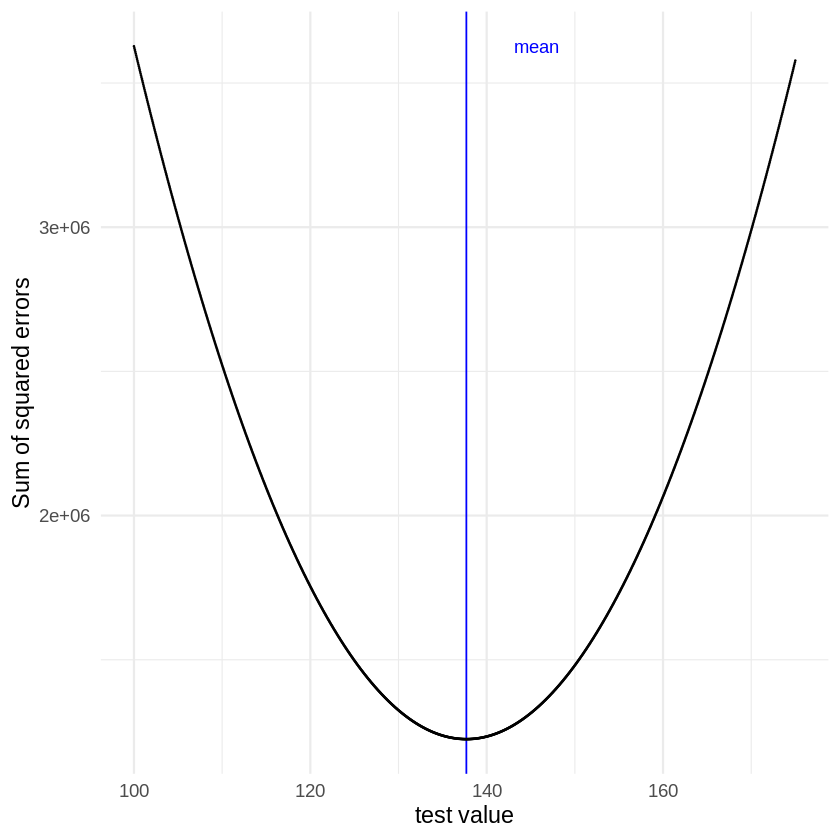

In [10]:
df_error <-
  tibble(
    val = seq(100, 175, 0.05),
    sse = NA
  )

for (i in 1:dim(df_error)[1]) {
  err <- NHANES_child$Height - df_error$val[i]
  df_error$sse[i] <- sum(err**2)
}

df_error %>%
  ggplot(aes(val, sse)) +
  geom_vline(xintercept = mean(NHANES_child$Height), color = "blue") +
  geom_point(size = 0.1) +
  annotate(
    "text",
    x = mean(NHANES_child$Height) + 8,
    y = max(df_error$sse),
    label = "mean",
    color = "blue"
  ) +
  labs(
    x = "test value",
    y = "Sum of squared errors"
  )

## Table 5.1

In [11]:
# create income data frame

incomeDf <-
  tibble(
  income = c(48000, 64000, 58000, 72000, 66000),
  person = c("Joe", "Karen", "Mark", "Andrea", "Pat")
)

kable(incomeDf, caption='Income for our five bar patrons')



Table: Income for our five bar patrons

| income|person |
|------:|:------|
|  48000|Joe    |
|  64000|Karen  |
|  58000|Mark   |
|  72000|Andrea |
|  66000|Pat    |

## Table 5.2

In [12]:
# add Beyonce to income data frame

incomeDf <-
  incomeDf %>%
  rbind(c(54000000, "Beyonce")) %>%
  mutate(income = as.double(income))

kable(incomeDf %>% mutate(income=format(income, scientific=FALSE)), caption='Income for our five bar patrons plus Beyoncé Knowles.')



Table: Income for our five bar patrons plus Beyoncé Knowles.

|income   |person  |
|:--------|:-------|
|48000    |Joe     |
|64000    |Karen   |
|58000    |Mark    |
|72000    |Andrea  |
|66000    |Pat     |
|54000000 |Beyonce |

## Table 5.3

In [13]:
# compare variance estimates using N or N-1 in denominator

population_variance <-
  NHANES_child %>%
  summarize(
    var(Height)
  ) %>%
  pull()


# take 100 samples and estimate the sample variance using both N or N-1  in the demoninator
sampsize <- 50
nsamp <- 10000
varhat_n <- array(data = NA, dim = nsamp)
varhat_nm1 <- array(data = NA, dim = nsamp)

for (i in 1:nsamp) {
  samp <- sample_n(NHANES_child, 1000)[1:sampsize, ]
  sampmean <- mean(samp$Height)
  sse <- sum((samp$Height - sampmean)**2)
  varhat_n[i] <- sse / sampsize
  varhat_nm1[i] <- sse / (sampsize - 1)
}

summary_df <- data.frame(Estimate=c("Population variance",
                                    "Variance estimate using n",
                                    "Variance estimate using n-1"),
                         Value=c(population_variance,
                                 mean(varhat_n),
                                 mean(varhat_nm1)))

kable(summary_df, digits=1, caption='Variance estimates using n versus n-1; the estimate using n-1 is closer to the population value')



Table: Variance estimates using n versus n-1; the estimate using n-1 is closer to the population value

|Estimate                    | Value|
|:---------------------------|-----:|
|Population variance         |   725|
|Variance estimate using n   |   710|
|Variance estimate using n-1 |   725|

## Figure 5.8

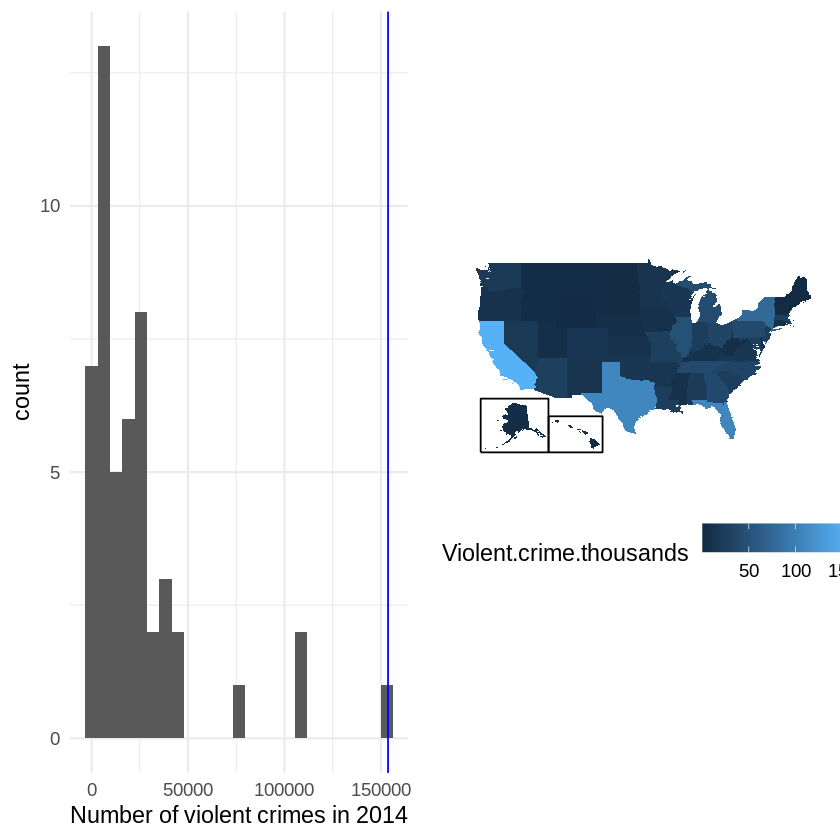

In [15]:
crimeData <-
  read.table(
    "https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/CrimeOneYearofData_clean.csv",
    header = TRUE,
    sep = ","
  )

# let's drop DC since it is so small
crimeData <-
  crimeData %>%
  dplyr::filter(State != "District of Columbia")

caCrimeData <-
  crimeData %>%
  dplyr::filter(State == "California")

p1 <- crimeData %>%
  ggplot(aes(Violent.crime.total)) +
  geom_histogram(bins = 25) +
  geom_vline(xintercept = caCrimeData$Violent.crime.total, color = "blue") +
  xlab("Number of violent crimes in 2014")

library(mapproj)
library(fiftystater)

data("fifty_states") # this line is optional due to lazy data loading

crimeData <-
  crimeData %>%
  mutate(StateLower = tolower(State),
         Violent.crime.thousands=Violent.crime.total/1000)

# map_id creates the aesthetic mapping to the state name column in your data
plot_map <-
  ggplot(crimeData, aes(map_id = StateLower)) +
  # map points to the fifty_states shape data
  geom_map(aes(fill = Violent.crime.thousands), map = fifty_states) +
  scale_x_continuous(breaks = NULL) +
  scale_y_continuous(breaks = NULL) +
  theme(
    legend.position = "bottom",
    panel.background = element_blank()
  ) +
  coord_map() +
  expand_limits(x = fifty_states$long, y = fifty_states$lat) +
  labs(
    x = "",
    y = ""
  )

# add border boxes to AK/HI
p2 <- plot_map + fifty_states_inset_boxes()

plot_grid(p1,p2)

## Figure 5.9

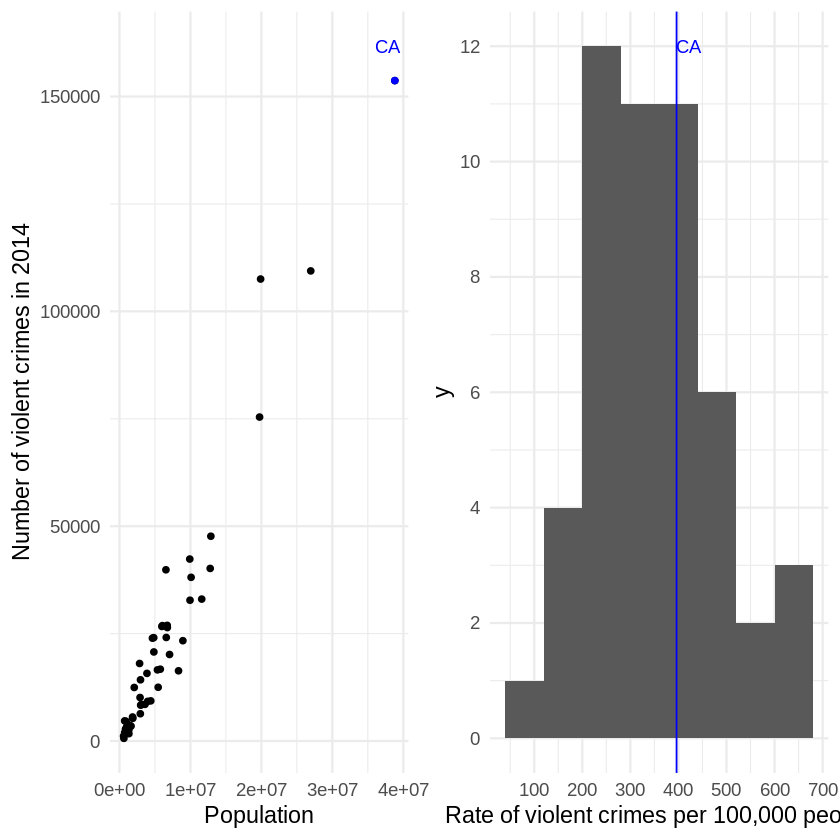

In [16]:
p1 <- crimeData %>%
  ggplot(aes(Population, Violent.crime.total)) +
  geom_point() +
  annotate(
    "point",
    x = caCrimeData$Population,
    y = caCrimeData$Violent.crime.total,
    color = "blue"
  ) +
  annotate(
    "text",
    x = caCrimeData$Population - 1000000,
    y = caCrimeData$Violent.crime.total + 8000,
    label = "CA",
    color = "blue"
  ) +
  ylab("Number of violent crimes in 2014")

p2 <- crimeData %>%
  ggplot(aes(Violent.Crime.rate)) +
  geom_histogram(binwidth = 80) +
  geom_vline(xintercept = caCrimeData$Violent.Crime.rate, color = "blue") +
  annotate(
    "text",
    x = caCrimeData$Violent.Crime.rate+25,
    y = 12,
    label = "CA",
    color = "blue"
  ) +
  scale_x_continuous(breaks = seq.int(0, 700, 100)) +
  scale_y_continuous(breaks = seq.int(0, 13, 2)) +
  xlab("Rate of violent crimes per 100,000 people")

plot_grid(p1,p2)

## Figure 5.10

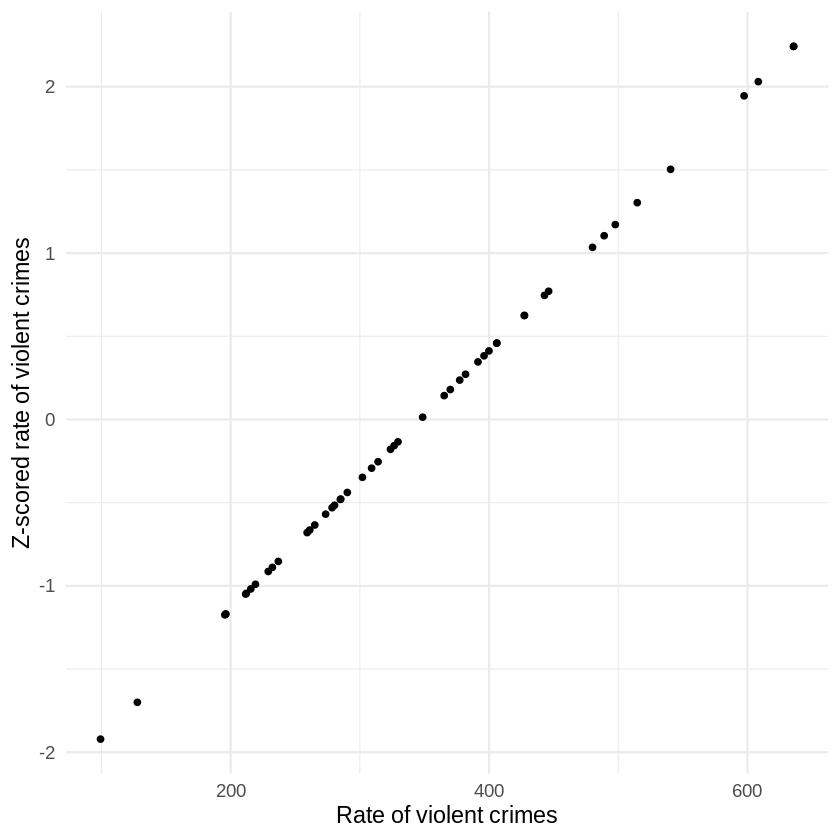

In [17]:
crimeData <-
  crimeData %>%
  mutate(
    ViolentCrimeRateZscore =
      (Violent.Crime.rate - mean(Violent.Crime.rate)) /
      sd(crimeData$Violent.Crime.rate)
    )

caCrimeData <-
  crimeData %>%
  dplyr::filter(State == "California")

crimeData %>%
  ggplot(aes(Violent.Crime.rate, ViolentCrimeRateZscore)) +
  geom_point() +
  labs(
    x = "Rate of violent crimes",
    y = "Z-scored rate of violent crimes"
  )

## Figure 5.11

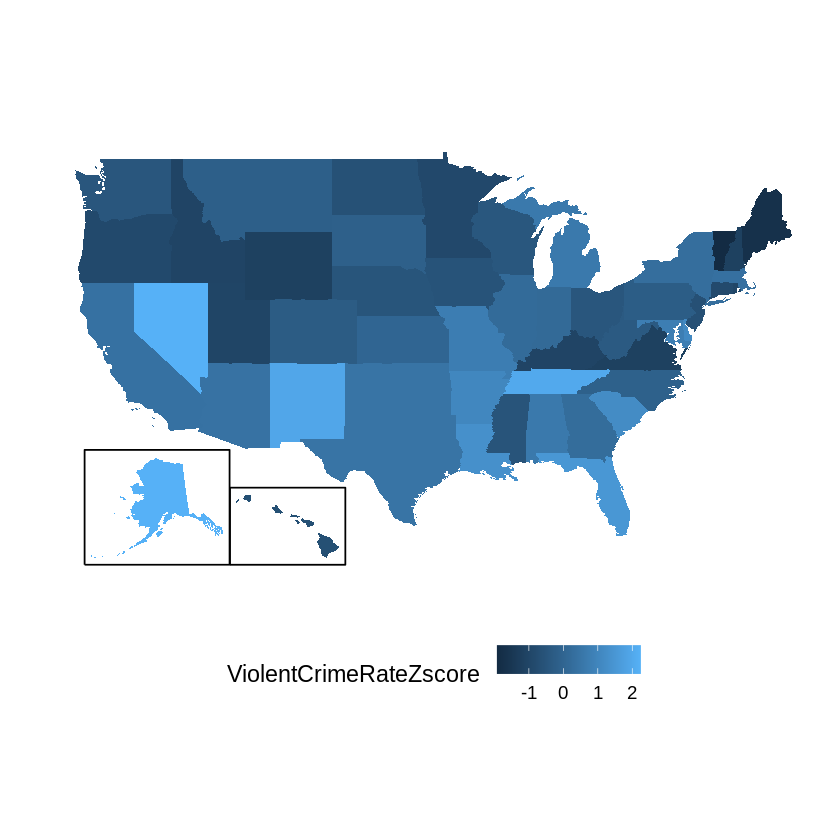

In [18]:
plot_map_z <-
  ggplot(crimeData, aes(map_id = StateLower)) +
  # map points to the fifty_states shape data
  geom_map(aes(fill = ViolentCrimeRateZscore), map = fifty_states) +
  expand_limits(x = fifty_states$long, y = fifty_states$lat) +
  scale_x_continuous(breaks = NULL) +
  scale_y_continuous(breaks = NULL) +
  theme(
    legend.position = "bottom",
    panel.background = element_blank()
  ) +
  coord_map() +
  expand_limits(x = fifty_states$long, y = fifty_states$lat) +
  labs(x = "", y = "")

# add border boxes to AK/HI
plot_map_z + fifty_states_inset_boxes()

## Figure 5.12

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


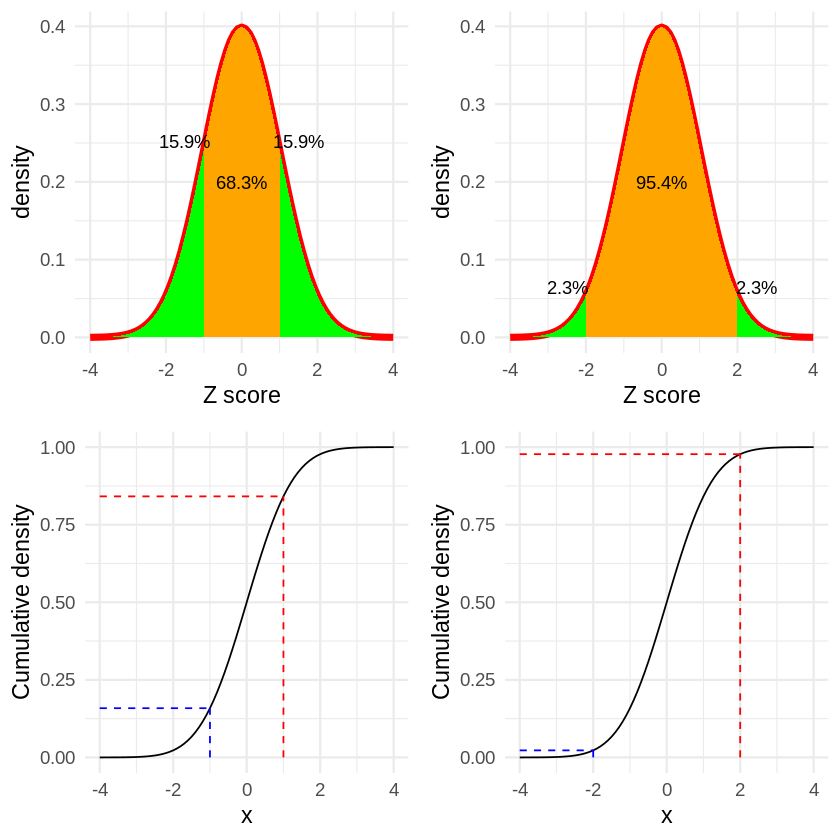

In [19]:
# First, create a function to generate plots of the density and CDF
dnormfun <- function(x) {
  return(dnorm(x, 248))
}

plot_density_and_cdf <-
  function(zcut, zmin = -4, zmax = 4, plot_cdf = TRUE, zmean = 0, zsd = 1) {
    zmin <- zmin * zsd + zmean
    zmax <- zmax * zsd + zmean
    x <- seq(zmin, zmax, 0.1 * zsd)
    zdist <- dnorm(x, mean = zmean, sd = zsd)
    area <- pnorm(zcut) - pnorm(-zcut)

    p2 <-
      tibble(
        zdist = zdist,
        x = x
      ) %>%
      ggplot(aes(x, zdist)) +
      geom_line(
        aes(x, zdist),
        color = "red",
        size = 2
      ) +
      stat_function(
        fun = dnorm, args = list(mean = zmean, sd = zsd),
        xlim = c(zmean - zcut * zsd, zmean + zsd * zcut),
        geom = "area", fill = "orange"
      ) +
      stat_function(
        fun = dnorm, args = list(mean = zmean, sd = zsd),
        xlim = c(zmin, zmean - zcut * zsd),
        geom = "area", fill = "green"
      ) +
      stat_function(
        fun = dnorm, args = list(mean = zmean, sd = zsd),
        xlim = c(zmean + zcut * zsd, zmax),
        geom = "area", fill = "green"
      ) +
      annotate(
        "text",
        x = zmean,
        y = dnorm(zmean, mean = zmean, sd = zsd) / 2,
        label = sprintf("%0.1f%%", area * 100)
      ) +
      annotate(
        "text",
        x = zmean - zsd * zcut - 0.5 * zsd,
        y = dnorm(zmean - zcut * zsd, mean = zmean, sd = zsd) + 0.01 / zsd,
        label = sprintf("%0.1f%%", pnorm(zmean - zsd * zcut, mean = zmean, sd = zsd) * 100)
      ) +
      annotate(
        "text",
        x = zmean + zsd * zcut + 0.5 * zsd,
        y = dnorm(zmean - zcut * zsd, mean = zmean, sd = zsd) + 0.01 / zsd,
        label = sprintf("%0.1f%%", (1 - pnorm(zmean + zsd * zcut, mean = zmean, sd = zsd)) * 100)
      ) +
      xlim(zmin, zmax) +
      labs(
        x = "Z score",
        y = "density"
      )

      cdf2 <-
        tibble(
          zdist = zdist,
          x = x,
          zcdf = pnorm(x, mean = zmean, sd = zsd)
        ) %>%
        ggplot(aes(x, zcdf)) +
        geom_line() +
        annotate(
          "segment",
          x = zmin,
          xend = zmean + zsd * zcut,
          y = pnorm(zmean + zsd * zcut, mean = zmean, sd = zsd),
          yend = pnorm(zmean + zsd * zcut, mean = zmean, sd = zsd),
          color = "red",
          linetype = "dashed"
        ) +
        annotate(
          "segment",
          x = zmean + zsd * zcut,
          xend = zmean + zsd * zcut,
          y = 0, yend = pnorm(zmean + zsd * zcut, mean = zmean, sd = zsd),
          color = "red",
          linetype = "dashed"
        ) +
        annotate(
          "segment",
          x = zmin,
          xend = zmean - zcut * zsd,
          y = pnorm(zmean - zcut * zsd, mean = zmean, sd = zsd),
          yend = pnorm(zmean - zcut * zsd, mean = zmean, sd = zsd),
          color = "blue",
          linetype = "dashed"
        ) +
        annotate(
          "segment",
          x = zmean - zcut * zsd,
          xend = zmean - zcut * zsd,
          y = 0,
          yend = pnorm(zmean - zcut * zsd, mean = zmean, sd = zsd),
          color = "blue",
          linetype = "dashed"
        ) +
        ylab("Cumulative density")


    return(list(pdf=p2, cdf=cdf2))
  }

plots1 = plot_density_and_cdf(1)
plots2 = plot_density_and_cdf(2)

plot_grid(plots1$pdf, plots2$pdf, plots1$cdf, plots2$cdf, nrow=2, ncol=2)

## Figure 5.13

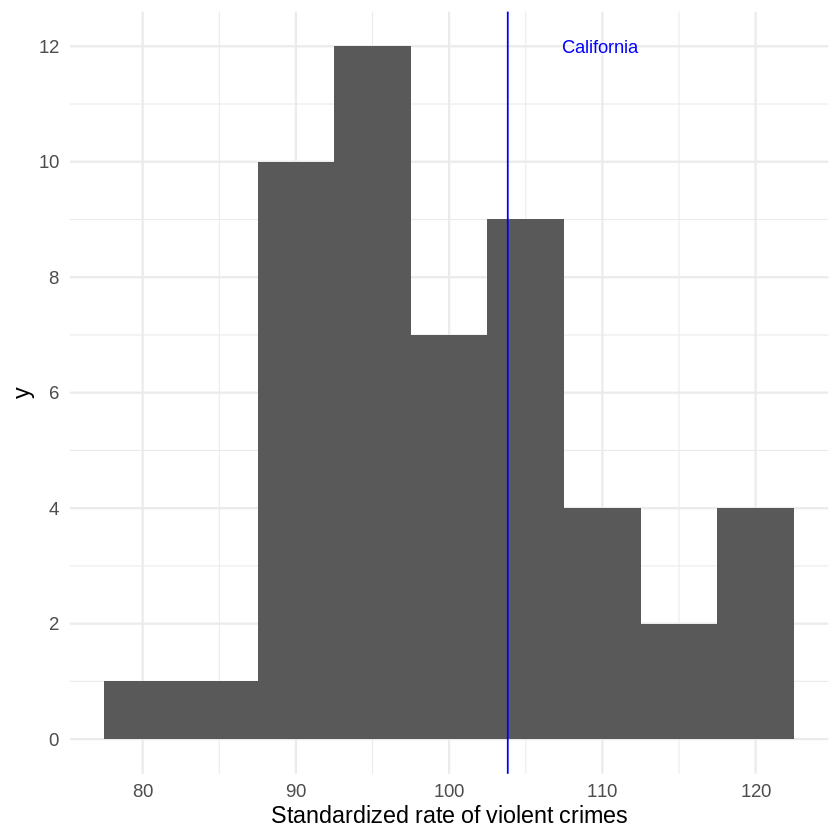

In [20]:
crimeData <-
  crimeData %>%
  mutate(
    ViolentCrimeRateStdScore = (ViolentCrimeRateZscore) * 10 + 100
  )

caCrimeData <-
  crimeData %>%
  filter(State == "California")

crimeData %>%
  ggplot(aes(ViolentCrimeRateStdScore)) +
  geom_histogram(binwidth = 5) +
  geom_vline(xintercept = caCrimeData$ViolentCrimeRateStdScore, color = "blue") +
  scale_y_continuous(breaks = seq.int(0, 13, 2)) +
  annotate(
    "text",
    x = caCrimeData$ViolentCrimeRateStdScore + 6,
    y = 12,
    label = "California",
    color = "blue"
  ) +
  labs(
    x = "Standardized rate of violent crimes"
  )

## Figure 5.14

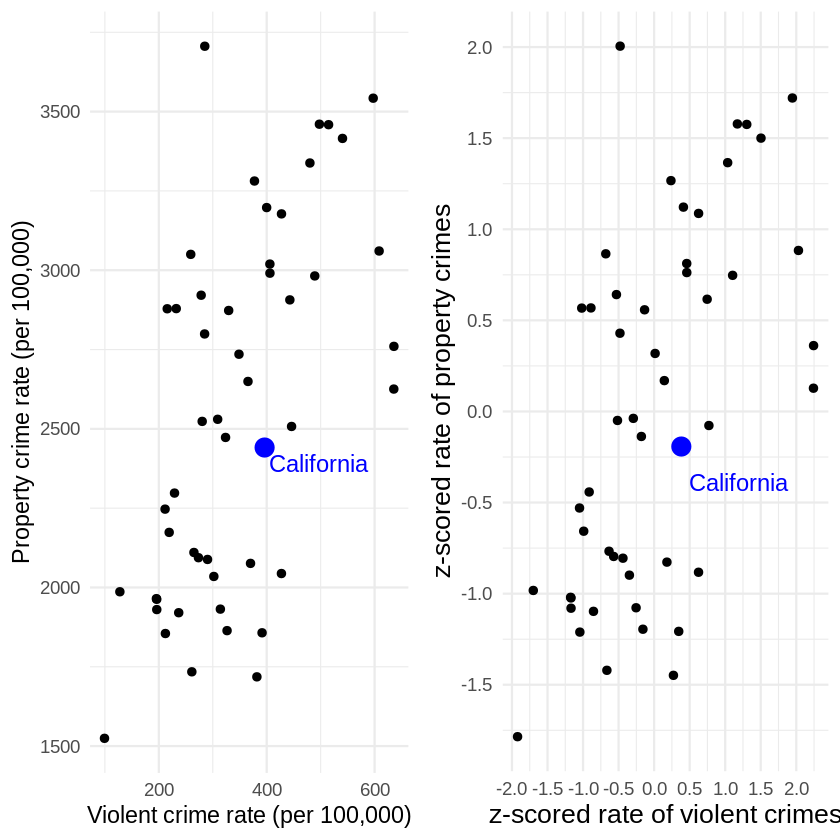

In [21]:
p1 <- crimeData %>%
  ggplot(aes(Violent.Crime.rate, Property.crime.rate)) +
  geom_point(size = 2) +
  annotate(
    "point",
    x = caCrimeData$Violent.Crime.rate,
    y = caCrimeData$Property.crime.rate,
    color = "blue",
    size = 5
  ) +
  annotate(
    "text",
    x = caCrimeData$Violent.Crime.rate + 100,
    y = caCrimeData$Property.crime.rate - 50,
    label = "California",
    color = "blue",
    size = 5
  ) +
  labs(
    x = "Violent crime rate (per 100,000)",
    y = "Property crime rate (per 100,000)"
  )

# plot z scores

crimeData <-
  crimeData %>%
  mutate(
    PropertyCrimeRateZscore =
      (Property.crime.rate - mean(Property.crime.rate)) /
      sd(Property.crime.rate)
  )

caCrimeData <-
  crimeData %>%
  dplyr::filter(State == "California")


p2 <- crimeData %>%
  ggplot(aes(ViolentCrimeRateZscore, PropertyCrimeRateZscore)) +
  geom_point(size = 2) +
  scale_y_continuous(breaks = seq.int(-2, 2, .5)) +
  scale_x_continuous(breaks = seq.int(-2, 2, .5)) +
  annotate(
    "point",
    x = caCrimeData$ViolentCrimeRateZscore,
    y = caCrimeData$PropertyCrimeRateZscore,
    color = "blue", size = 5
  ) +
  annotate(
    "text",
    x = caCrimeData$ViolentCrimeRateZscore + 0.8,
    y = caCrimeData$PropertyCrimeRateZscore  - 0.2,
    label = "California",
    color = "blue",
    size = 5
  ) +
  theme(
    axis.title = element_text(size = 16)
  ) +
  labs(
    x = "z-scored rate of violent crimes",
    y = "z-scored rate of property crimes"
  )

plot_grid(p1,p2)

## Figure 5.15

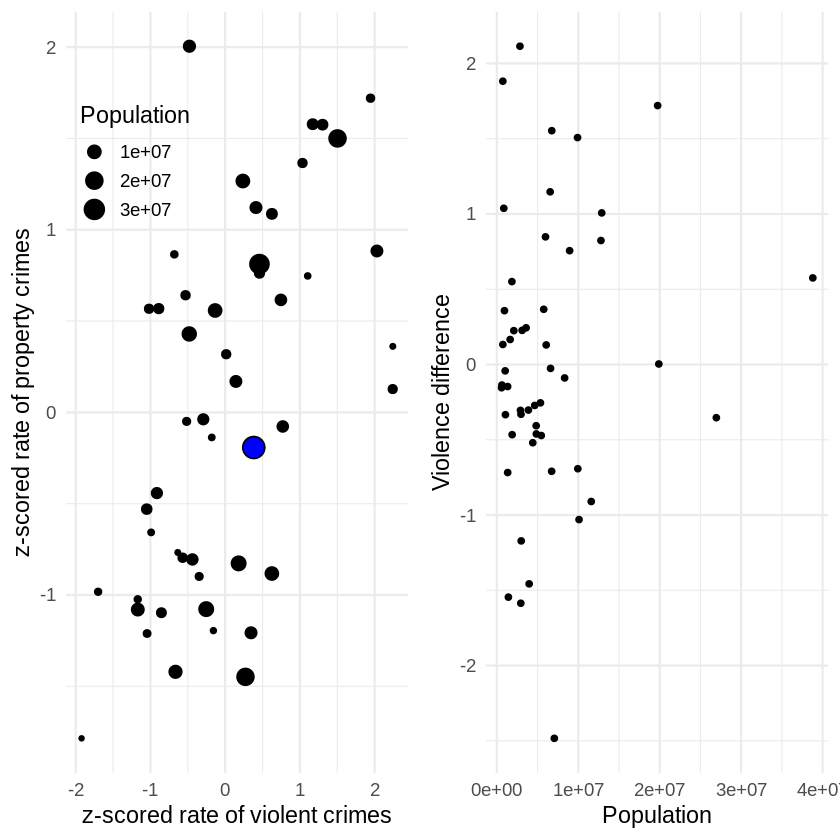

In [22]:
p1 <- crimeData %>%
  ggplot(aes(ViolentCrimeRateZscore, PropertyCrimeRateZscore)) +
  geom_point(aes(size = Population)) +
  annotate(
    "point",
    x = caCrimeData$ViolentCrimeRateZscore,
    y = caCrimeData$PropertyCrimeRateZscore,
    color = "blue",
    size = 5
  ) +
  labs(
    x = "z-scored rate of violent crimes",
    y = "z-scored rate of property crimes"
  ) +
  theme(legend.position = c(0.2,0.8))

crimeData <- crimeData %>%
  mutate(
    ViolenceDiff = ViolentCrimeRateZscore - PropertyCrimeRateZscore
  )

p2 <- crimeData %>%
  ggplot(aes(Population, ViolenceDiff)) +
  geom_point() +
  ylab("Violence difference")

plot_grid(p1,p2)